In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error
from time import time
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import statsmodels.tsa.api as smt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
df_example = pd.read_excel(r'sarima_sample.xlsx', 'sample', usecols = ['Date','netsales'], parse_dates = [0],index_col =0, squeeze = True)#, date_parser = parser )

In [3]:
display(df_example.head(4))
display(df_example.shape)
display(df_example.describe())

Date
1970-10-01   2196570.82
1970-11-01   2234790.84
1970-12-01   2714572.20
1971-01-01   2700282.60
Name: netsales, dtype: float64

(36,)

count        36.00
mean    2642610.04
std     1114576.34
min      323214.42
25%     2315969.67
50%     2905670.95
75%     3318853.98
max     4681297.56
Name: netsales, dtype: float64

In [4]:
df_example.isna().value_counts()

False    36
Name: netsales, dtype: int64

## Process my data

In [5]:
df_example = df_example.asfreq(pd.infer_freq(df_example.index))
df_example = df_example.sort_index(ascending = True)
df_example.head()

Date
1970-10-01   2196570.82
1970-11-01   2234790.84
1970-12-01   2714572.20
1971-01-01   2700282.60
1971-02-01   3196842.46
Freq: MS, Name: netsales, dtype: float64

In [6]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=35)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


(<AxesSubplot:title={'center':'Sales Trend'}, xlabel='Date'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

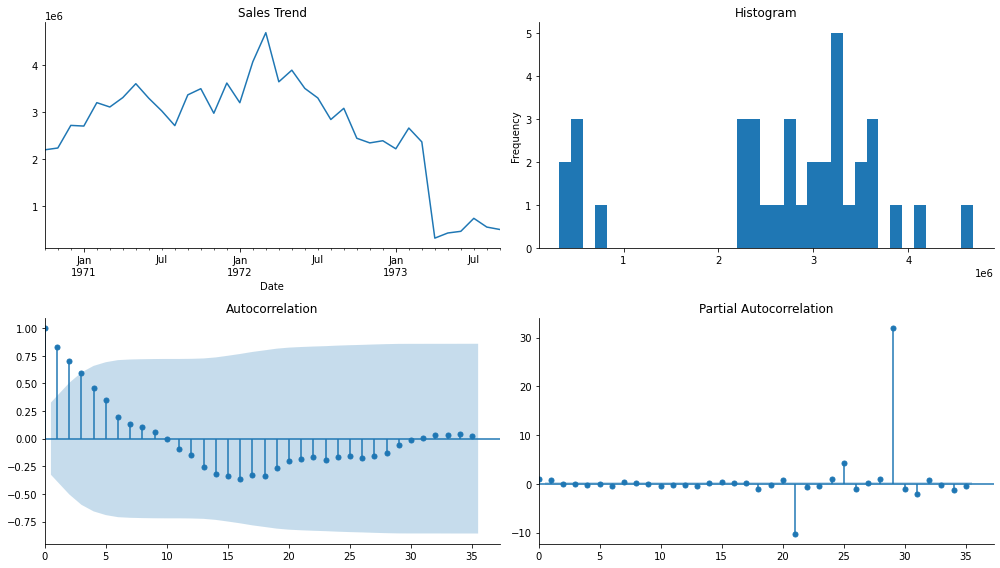

In [7]:
tsplot(df_example, lags = 35, title = 'Sales Trend')

In [8]:
first_diff = df_example.diff()[1:]

In [9]:
display(df_example.head())
display(first_diff.head())
print(2234790.84 -2196570.82)

Date
1970-10-01   2196570.82
1970-11-01   2234790.84
1970-12-01   2714572.20
1971-01-01   2700282.60
1971-02-01   3196842.46
Freq: MS, Name: netsales, dtype: float64

Date
1970-11-01    38220.02
1970-12-01   479781.36
1971-01-01   -14289.60
1971-02-01   496559.86
1971-03-01   -92157.48
Freq: MS, Name: netsales, dtype: float64

38220.02000000002


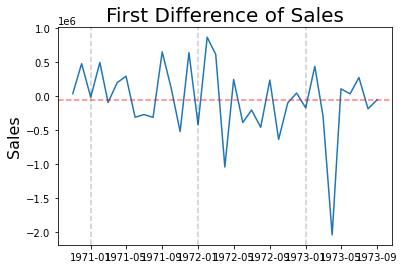

In [10]:
plt.plot(first_diff)
plt.title('First Difference of Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(1971,1974):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.5, linestyle='--')

In [11]:
first_diff = first_diff.fillna(value = 0)

## Dickey Full Test

In [12]:
def test_stationarity(df):

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df.values, 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if dftest[0] < dftest[4]["5%"]:
        print ('Reject Ho - Time Series is Stationary \n \n  \n')
    print (dfoutput)
#     print( '\n \n \n \n')
#     print(dftest)

In [13]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
test_stationarity(first_diff)

Results of Dickey-Fuller Test:
Reject Ho - Time Series is Stationary 
 
  

Test Statistic                -6.6054087830
p-value                        0.0000000066
# Lags Used                    0.0000000000
Number of Observations Used   34.0000000000
Critical Value (1%)           -3.6392241044
Critical Value (5%)           -2.9512301791
Critical Value (10%)          -2.6144469896
dtype: float64


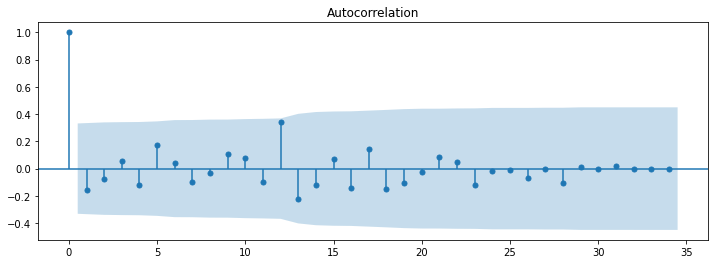

In [14]:
rcParams['figure.figsize'] = 12, 4
acf_plot = plot_acf(first_diff, lags=34) # for MA

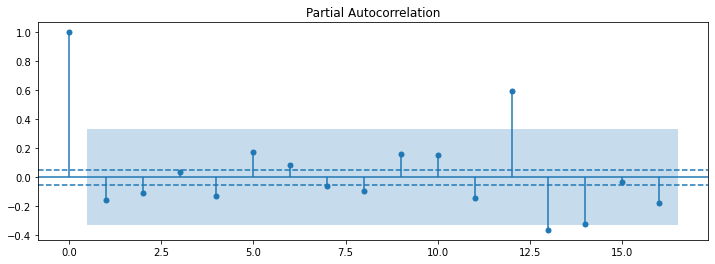

In [15]:
pacf_plot = plot_pacf(first_diff) #for AR
plt.axhline(y=0.05,linestyle='--')
plt.axhline(y=-0.05,linestyle='--')

### Based on PACF, we can start with a AR(5) process as it's the strongest among the first couple lags
### Also, it's pretty strong lag at 12, so it indicates a possible seasonal pattern

# First, let's try <font color='green'>ARIMA</font> Model.

In [16]:
# Train Test Split
from datetime import timedelta
from datetime import datetime
train_start = datetime(1972,3,1)
train_end = datetime(1973,6,1)
test_end = datetime(1973,9,1)

train_data = df_example[:train_end]
test_data = df_example[train_end + timedelta(days=1):test_end]

In [17]:
display(train_data.head())
test_data

Date
1970-10-01   2196570.8167195786
1970-11-01   2234790.8389889989
1970-12-01   2714572.1967379833
1971-01-01   2700282.5966417077
1971-02-01   3196842.4587025498
Freq: MS, Name: netsales, dtype: float64

Date
1973-07-01   743352.4893044571
1973-08-01   557729.3958603279
1973-09-01   506702.8319238428
Freq: MS, Name: netsales, dtype: float64

In [18]:
df_shown = pd.read_excel(r'sarima_sample.xlsx', 'sample', usecols = ['Date','netsales'], parse_dates = [0],index_col =0)

In [19]:
split_date = '01-Jun-1973'
df_shown_train = df_shown.loc[df_shown.index <= split_date].copy()
df_shown_test = df_shown.loc[df_shown.index > split_date].copy()

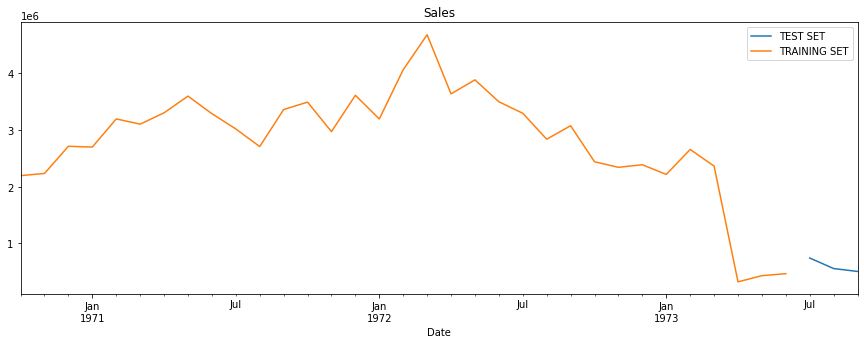

In [20]:
df_shown_test\
.rename(columns={'netsales': 'TEST SET'}) \
    .join(df_shown_train.rename(columns={'netsales': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Sales', style='-')
plt.show()

In [21]:
# ARIMA model
model = ARIMA(train_data, order=(5, 1, 1)) 

start = time()
model_fit = model.fit(disp=0)  
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.1855309009552002


In [22]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.netsales   No. Observations:                   32
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -466.835
Method:                       css-mle   S.D. of innovations         520494.157
Date:                Fri, 05 Feb 2021   AIC                            949.671
Time:                        01:21:20   BIC                            961.396
Sample:                    11-01-1970   HQIC                           953.557
                         - 06-01-1973                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5.403e+04   9.91e+04     -0.545      0.585   -2.48e+05     1.4e+05
ar.L1.D.netsales     0.1909      0.778      0.246      0.806      -1.333       1.715
ar.L2.D.netsales    -0.0757 

In [23]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
display(pred_start_date)
pred_end_date

Timestamp('1973-07-01 00:00:00', freq='MS')

Timestamp('1973-09-01 00:00:00', freq='MS')

In [24]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

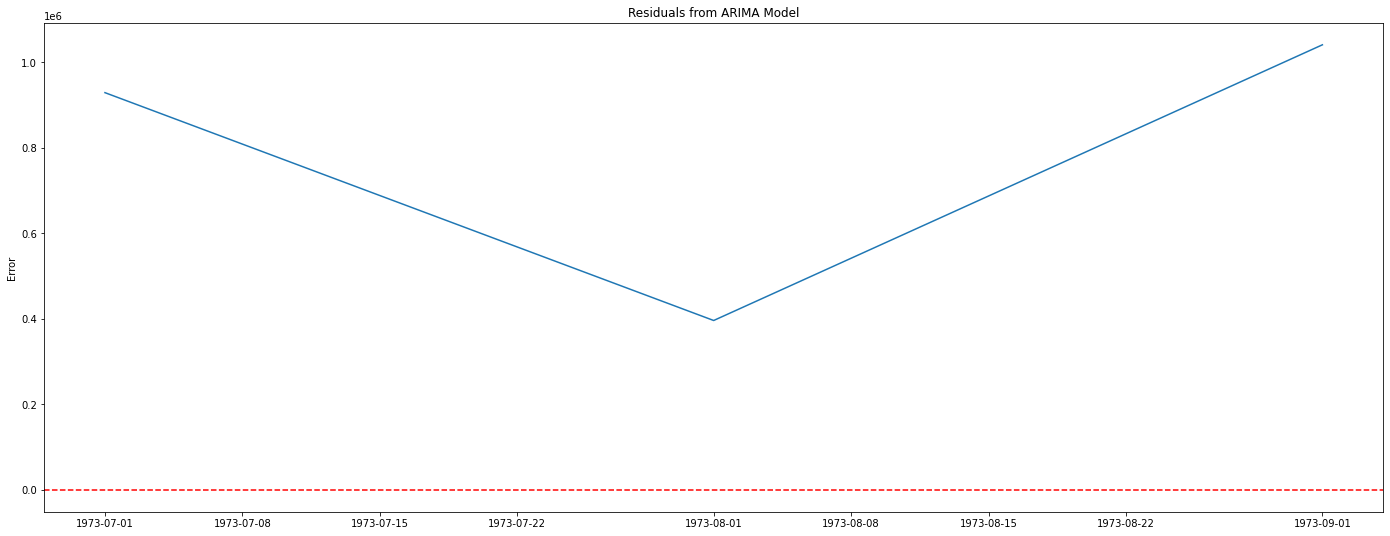

In [25]:
rcParams['figure.figsize'] = 24, 9
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.ylabel('Error')
plt.axhline(0, color = 'r', linestyle = '--')

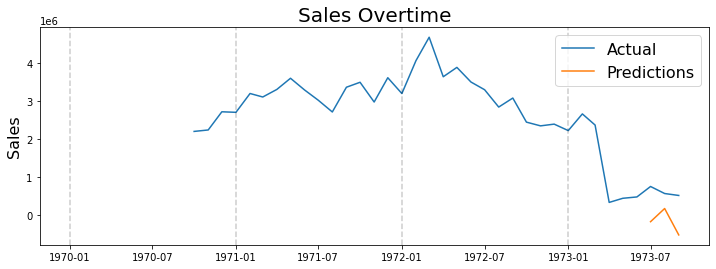

In [26]:
plt.figure(figsize=(12,4))
plt.plot(df_example)
plt.plot(predictions)

plt.legend(('Actual', 'Predictions'), fontsize=16)

plt.title('Sales Overtime', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(1970,1974):
    plt.axvline(pd.to_datetime(str((year))+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [27]:
print('Mean Absolute Percent Error:', "{:.2%}".format(round(np.mean(abs(residuals/test_data)),4)))

Mean Absolute Percent Error: 133.80%


In [28]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 837408.3588781282


In [29]:
print('It is a bad model, let''s try Seasonal ARIMA model.')

It is a bad model, lets try Seasonal ARIMA model.


# <font color='blue'>SARIMA MODEL</font>

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
my_order = (0,1,0)                   
my_seasonal_order = (1,0,1,12)       
model2 = SARIMAX(train_data, order = my_order, seasonal_order= my_seasonal_order)

In [32]:
start = time()
model2_fit = model2.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.07396507263183594


In [33]:
print(model2_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             netsales   No. Observations:                   33
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -465.678
Date:                              Fri, 05 Feb 2021   AIC                            937.357
Time:                                      01:21:20   BIC                            941.754
Sample:                                  10-01-1970   HQIC                           938.815
                                       - 06-01-1973                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1528      0.916     -0.167      0.868      -1.949       1.643
ma.S.L12       0.60

In [34]:
predictions2 = model2_fit.forecast(len(test_data))
predictions2 = pd.Series(predictions2, index=test_data.index)
residuals2 = test_data - predictions2
residuals2

Date
1973-07-01   307148.1619757421
1973-08-01   250914.8403315539
1973-09-01   230407.3680861273
Freq: MS, dtype: float64

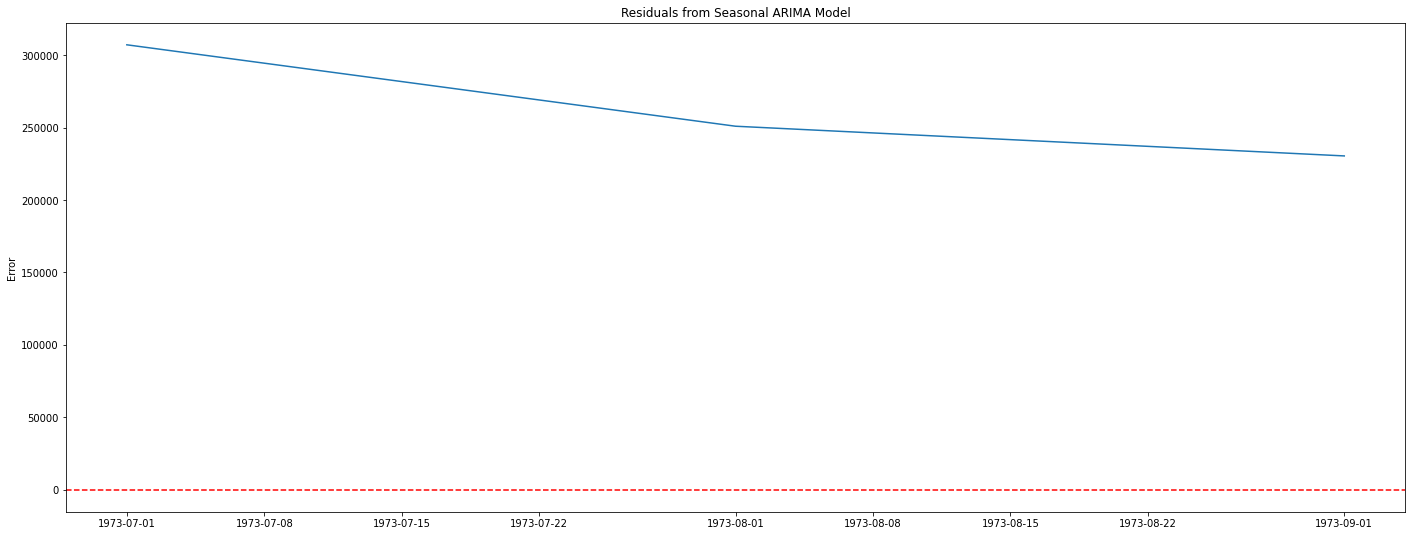

In [35]:
plt.plot(residuals2)
plt.title('Residuals from Seasonal ARIMA Model')
plt.ylabel('Error')
plt.axhline(0, color = 'r', linestyle = '--')

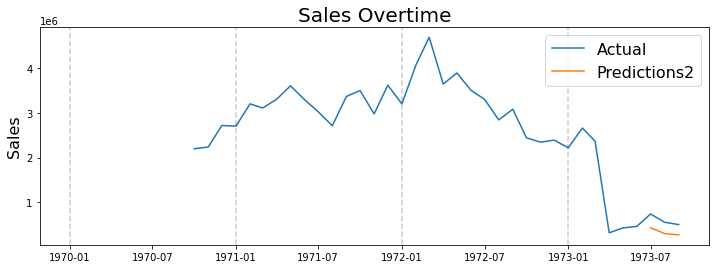

In [36]:
plt.figure(figsize=(12,4))
plt.plot(df_example)
plt.plot(predictions2)

plt.legend(('Actual', 'Predictions2'), fontsize=16)

plt.title('Sales Overtime', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(1970,1974):
    plt.axvline(pd.to_datetime(str((year))+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [37]:
print('Mean Absolute Percent Error:', "{:.2%}".format(round(np.mean(abs(residuals2/test_data)),4)))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals2**2)))

Mean Absolute Percent Error: 43.93%
Root Mean Squared Error: 264818.0543770018


###### The model improves a lot by using SARIMA model!

# Let's try using the Rolling Forecast Origin to predict 1 month by 1 month

In [38]:
rolling_predictions = pd.Series()
for end_date in test_data.index:
    train_data = df_example[:end_date - timedelta(days = 1)]  #prediction 1 month forward each time
    model = SARIMAX(train_data, order=my_order, seasonal_order = my_seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[end_date] = pred

In [39]:
rolling_residuals = test_data - rolling_predictions
display(rolling_predictions)
rolling_residuals

1973-07-01    1973-07-01   436204.3273287150
Freq: MS, dtype...
1973-08-01    1973-08-01   615114.9177651795
Freq: MS, dtype...
1973-09-01    1973-09-01   525857.0216386688
Freq: MS, dtype...
dtype: object

Date
1973-07-01    1973-07-01   307148.1619757421
Freq: MS, dtype...
1973-08-01    1973-08-01   -57385.5219048517
Freq: MS, dtype...
1973-09-01    1973-09-01   -19154.1897148261
Freq: MS, dtype...
Freq: MS, dtype: object

Text(0, 0.5, 'Error')

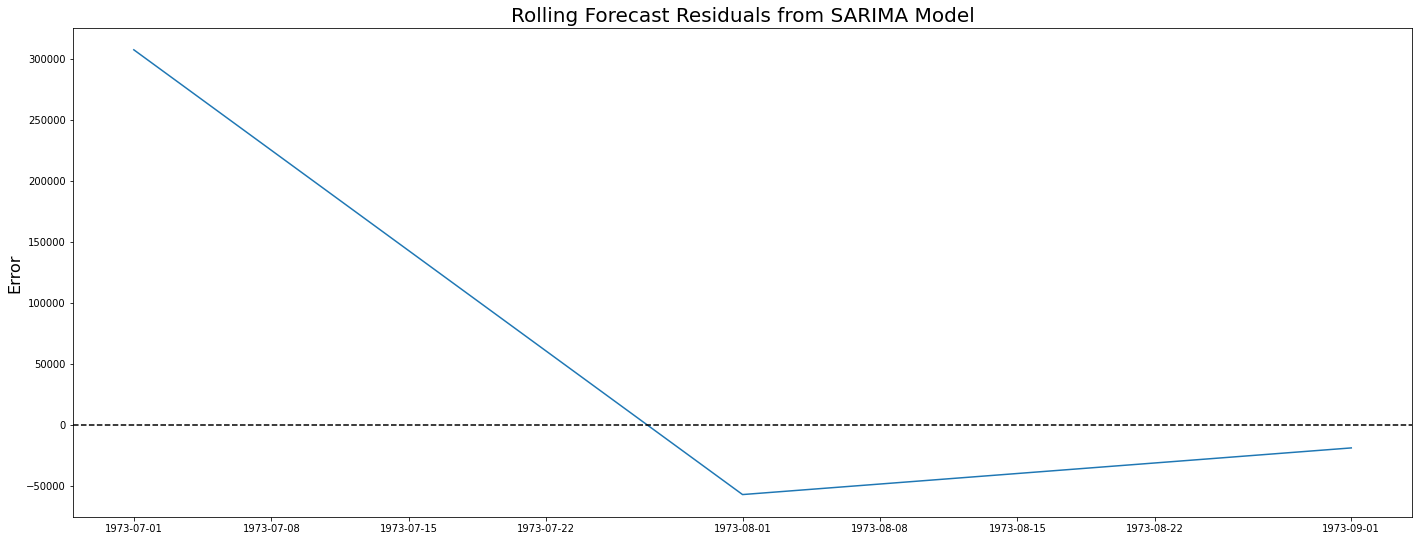

In [40]:
plt.plot(rolling_residuals)
plt.axhline(0, linestyle = '--', color = 'k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)

Text(0, 0.5, 'Sales')

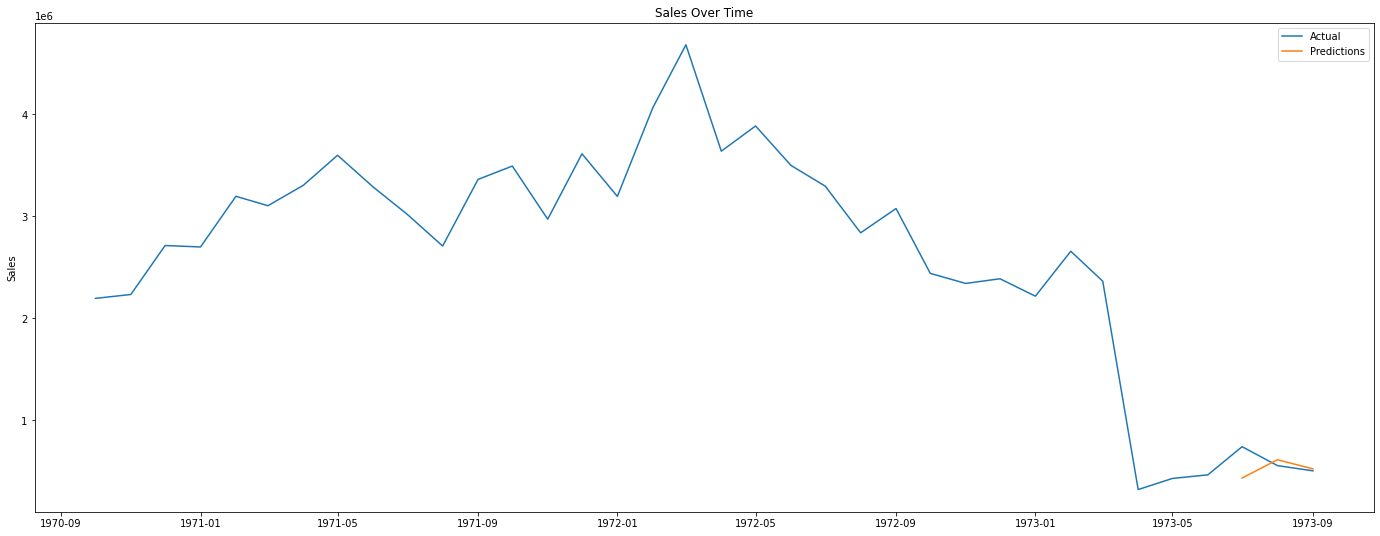

In [41]:
plt.plot(df_example)
plt.plot(rolling_predictions)
plt.legend(('Actual', 'Predictions'))
plt.title('Sales Over Time')
plt.ylabel('Sales')

In [42]:
print('Mean Absolute Percent Error:', "{:.2%}".format(round(np.mean(abs(([item[0] for item in rolling_residuals.values])/test_data)),4)))
print('Root Mean Squared Error:', np.sqrt(np.mean([item[0]**2 for item in rolling_residuals.values])))

Mean Absolute Percent Error: 18.46%
Root Mean Squared Error: 180739.19932045773


# It's way even better!

In [43]:
stl = STL(df_example)
result = stl.fit()

In [44]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

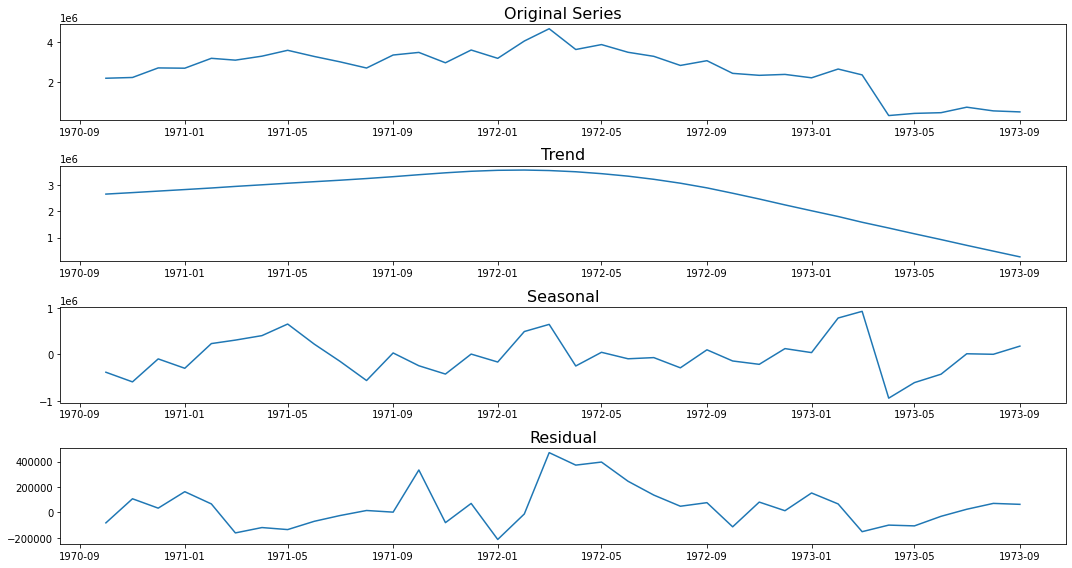

In [45]:
plt.figure(figsize=(15,8))

plt.subplot(4,1,1)
plt.plot(df_example)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

#####  STL assumes that the original series is <u>made up of a trend added to a seasonal component.</u> Anything that's left over is the residual, which is a compoenent for detecting anomaly.

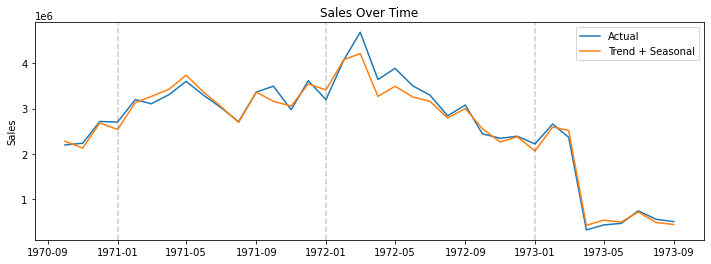

In [46]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df_example)
plt.plot(estimated)
plt.legend(('Actual', 'Trend + Seasonal'))
plt.title('Sales Over Time')
plt.ylabel('Sales')
for year in range(1971,1974):
    plt.axvline(pd.to_datetime(str((year))+'-01-01'), color='k', linestyle='--', alpha=0.2)